# Chinese characters generator 

In [1]:
import os
import time
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D, Conv2DTranspose, Conv2D
from keras.layers.advanced_activations import LeakyReLU

from keras.optimizers import SGD, RMSprop

Using TensorFlow backend.


## Data

In [3]:
filename = "./data/vector300_to_char64x64_27_03_18_20_13_48.txt"

X_vec = []
Y_img = []

img_size = 64
w_number = 120000

start_time = time.time()
i = 0

for line in open(filename):
    vec, img = line[:-1].split(",")
    
    vec = np.array([float(n) for n in vec.split(" ")])
    img = np.array([(float(n) - 127) / 127 for n in img.split(" ")])
        
    img = np.reshape(img, (img_size, img_size, 1))
    
    X_vec.append(vec)
    Y_img.append(img)
    
    i += 1
    if (i % 10000 == 0):
        curr_time = time.time()
        if i > 0:
            time_est = (curr_time - start_time) * (w_number - i) / i
        else:
            time_est = (curr_time - start_time) * w_number
        time_est_str = str(timedelta(seconds=time_est)).split('.')[0]
        
        print("{} words processed | Time est {}".format(i, time_est_str))
    if i > w_number:
        break
        
print("{} words processed".format(i))

Y_img = np.array(Y_img)
X_vec = np.array(X_vec)

10000 words processed | Time est 0:02:04
20000 words processed | Time est 0:01:52
30000 words processed | Time est 0:01:41
40000 words processed | Time est 0:01:30
50000 words processed | Time est 0:01:18
60000 words processed | Time est 0:01:07
70000 words processed | Time est 0:00:56
80000 words processed | Time est 0:00:44
90000 words processed | Time est 0:00:33
100000 words processed | Time est 0:00:22
110000 words processed | Time est 0:00:11
120000 words processed | Time est 0:00:00
120001 words processed


In [4]:
Y_img.shape, np.min(Y_img), np.max(Y_img)

((120001, 64, 64, 1), -1.0, 1.0078740157480315)

## Visualisation

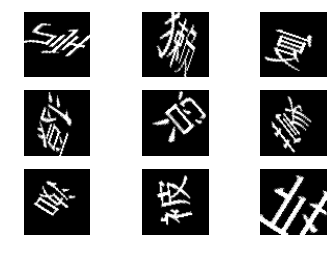

In [5]:
images = Y_img[np.random.randint(0, Y_img.shape[0], 
                                 size=9)]

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(images[i].reshape(img_size, img_size), cmap=plt.get_cmap('gray'))
    plt.axis('off')
plt.show()

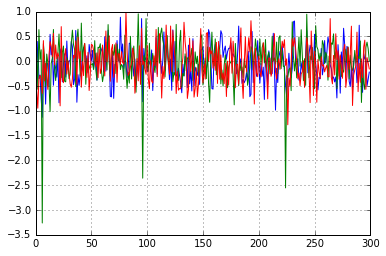

In [6]:
vectors = X_vec[np.random.randint(0, X_vec.shape[0], size=3)]

for i in range(3):
    plt.plot(vectors[i])
    
plt.grid()
plt.show()

# GAN
## Generator

In [7]:
gen_dropout = 0.3
gen_input_dim = 8
gen_depth = 512
gen_noise_dim = 300
# gen_alpha = 0.2
gen_beta = 0.9

In [19]:
gennet = Sequential()

# Input 
# fully-connected layer
gennet.add(Dense(gen_input_dim * gen_input_dim * gen_depth, 
                 input_dim=gen_noise_dim))
gennet.add(Reshape((gen_input_dim, gen_input_dim, gen_depth)))
gennet.add(BatchNormalization(momentum=gen_beta))
gennet.add(Activation('relu'))
gennet.add(Dropout(gen_dropout))

# Deconvolution layers
gennet.add(UpSampling2D())
gennet.add(Conv2DTranspose(int(gen_depth / 2), 5, padding='same'))
gennet.add(BatchNormalization(momentum=gen_beta))
gennet.add(Activation('relu'))
# gennet.add(Dropout(gen_dropout))

# gennet.add(Conv2DTranspose(int(gen_depth / 2), 5, padding='same'))
# gennet.add(BatchNormalization(momentum=gen_beta))
# gennet.add(Activation('relu'))
# gennet.add(Dropout(gen_dropout))


gennet.add(UpSampling2D())
gennet.add(Conv2DTranspose(int(gen_depth / 4), 5, padding='same'))
gennet.add(BatchNormalization(momentum=gen_beta))
gennet.add(Activation('relu'))
# gennet.add(Dropout(gen_dropout))

gennet.add(Conv2DTranspose(int(gen_depth / 4), 5, padding='same'))
gennet.add(BatchNormalization(momentum=gen_beta))
gennet.add(Activation('relu'))
# gennet.add(Dropout(gen_dropout))


gennet.add(UpSampling2D())
gennet.add(Conv2DTranspose(int(gen_depth / 8), 5, padding='same'))
gennet.add(BatchNormalization(momentum=gen_beta))
gennet.add(Activation('relu'))
# gennet.add(Dropout(gen_dropout))

gennet.add(Conv2DTranspose(int(gen_depth / 8), 5, padding='same'))
gennet.add(BatchNormalization(momentum=gen_beta))
gennet.add(Activation('relu'))
# gennet.add(Dropout(gen_dropout))


# gennet.add(UpSampling2D())
gennet.add(Conv2DTranspose(int(gen_depth / 16), 5, padding='same'))
gennet.add(BatchNormalization(momentum=gen_beta))
gennet.add(Activation('relu'))
# gennet.add(Dropout(gen_dropout))

# gennet.add(Conv2DTranspose(int(gen_depth / 16), 5, padding='same'))
# gennet.add(BatchNormalization(momentum=gen_beta))
# gennet.add(Activation('relu'))
# gennet.add(Dropout(gen_dropout))

# Output
gennet.add(Conv2DTranspose(1, 5, padding='same'))
gennet.add(Activation('tanh'))

gennet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32768)             9863168   
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 512)         0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 8, 8, 512)         2048      
_________________________________________________________________
activation_10 (Activation)   (None, 8, 8, 512)         0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 8, 8, 512)         0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 16, 16, 256)       3277056   
__________

## Discriminator

In [20]:
disc_depth = 32
disc_dropout = 0.3
disc_alpha = 0.0
disc_beta = 0.9

In [21]:
discnet = Sequential()

# Input
discnet.add(Conv2D(disc_depth, 5, strides=2, input_shape=(img_size, img_size, 1), 
                   padding='same'))
# discnet.add(BatchNormalization(momentum=disc_beta))
discnet.add(LeakyReLU(alpha=disc_alpha))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*2, 5, strides=2, padding='same'))
# discnet.add(BatchNormalization(momentum=disc_beta))
discnet.add(LeakyReLU(alpha=disc_alpha))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*4, 5, strides=2, padding='same'))
# discnet.add(BatchNormalization(momentum=disc_beta))
discnet.add(LeakyReLU(alpha=disc_alpha))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*8, 5, strides=2, padding='same'))
# discnet.add(BatchNormalization(momentum=disc_beta))
discnet.add(LeakyReLU(alpha=disc_alpha))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*16, 5, strides=2, padding='same'))
# discnet.add(BatchNormalization(momentum=disc_beta))
discnet.add(LeakyReLU(alpha=disc_alpha))
discnet.add(Dropout(disc_dropout))

# Out: scalar estimation of probability
discnet.add(Flatten())
discnet.add(Dense(1))
discnet.add(Activation('sigmoid'))

discnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        832       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        51264     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 128)         204928    
__________

## Discriminator model

In [22]:
discmodel = Sequential()
discmodel.add(discnet)
discmodel.compile(loss='binary_crossentropy', 
                  optimizer=RMSprop(lr=0.0002, clipvalue=1.0, decay=6e-8),
                  metrics=['accuracy'])

## Adversarial model

In [23]:
advmodel = Sequential()
advmodel.add(gennet)
advmodel.add(discnet)
advmodel.compile(loss='binary_crossentropy', 
                 optimizer=RMSprop(lr=0.0001, clipvalue=1.0, decay=3e-8),
                 metrics=['accuracy'])

## Training

In [24]:
disc_losses = {"loss": [], "acc": []}
adv_losses = {"loss": [], "acc": []}

log_images_noise = np.random.uniform(-1.0, 1.0, size=[9, gen_noise_dim])

In [25]:
batch_size = 128
train_iters = 1000
stop_loss = 7.0

disc_loss = [1.0, 0.0]
adv_loss = [1.0, 0.0]

log_step = 100
log_images = False
log_images_dir = "./data/images_{}/".format(datetime.now().strftime("%d_%m_%y_%H_%M_%S"))

if log_images:
    if not os.path.exists(log_images_dir):
        os.makedirs(log_images_dir)
    print("Loging images to: {}".format(log_images_dir))

In [ ]:
start_time = time.time()

for i in range(train_iters):
    # Compose trainig data for adversarial net
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, gen_noise_dim])
    y = np.ones([batch_size, 1])
    # Train adversarial net on composed data
    adv_loss = advmodel.train_on_batch(noise, y)
    adv_losses["loss"].append(adv_loss[0])
    adv_losses["acc"].append(adv_loss[1])
    
    # Get random real images
    images_true = Y_img[np.random.randint(0, 
                                          Y_img.shape[0], 
                                          size=batch_size)]
    # Generate images from noise
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, gen_noise_dim])
    images_fake = gennet.predict(noise)
    # Compose training data for discriminator
    x = np.concatenate((images_true, images_fake))
    y = np.concatenate((np.ones((batch_size, 1)), 
                        np.zeros((batch_size, 1))))
    # Train discriminator on composed data
    disc_loss = discmodel.train_on_batch(x, y)
    disc_losses["loss"].append(disc_loss[0])
    disc_losses["acc"].append(disc_loss[1])
    
    # Print results
    if i % log_step == 0:
        curr_time = time.time()
        if i > 0:
            time_est = (curr_time - start_time) * (train_iters - i) / i
        else:
            time_est = (curr_time - start_time) * train_iters
        time_est_str = str(timedelta(seconds=time_est)).split('.')[0]
        print("{:4d}th batch of {:4d}|".format(i, train_iters) + \
              "Disc loss {:.3f} |acc {:.3f} |Adv loss {:.3f} | acc {:.3}|".format(disc_loss[0], 
                                                                                  disc_loss[1], 
                                                                                  adv_loss[0], 
                                                                                  adv_loss[1]) +\
              "Time est {}".format(time_est_str))
        
        if log_images:
            filename = "{}img_{}.png".format(log_images_dir, i)
            images = gennet.predict(log_images_noise)
            
            plt.figure(figsize=(10,10))
            for j in range(9):
                plt.subplot(330 + 1 + j)
                plt.imshow(images[j].reshape(img_size, img_size), cmap=plt.get_cmap('gray'))
                plt.axis('off')
            
            plt.savefig(filename)
            plt.close('all')
            
# Log final result
if log_images:
    filename = "{}img_{}.png".format(log_images_dir, str(train_iters))
    images = gennet.predict(log_images_noise)

    plt.figure(figsize=(10,10))
    for j in range(9):
        plt.subplot(330 + 1 + j)
        plt.imshow(images[j].reshape(img_size, img_size), cmap=plt.get_cmap('gray'))
        plt.axis('off')

    plt.savefig(filename)
    plt.close('all')

   0th batch of 1000|Disc loss 0.617 |acc 0.500 |Adv loss 0.696 | acc 0.398|Time est 0:50:49
 100th batch of 1000|Disc loss 0.265 |acc 0.953 |Adv loss 1.024 | acc 0.133|Time est 0:08:31
 200th batch of 1000|Disc loss 0.624 |acc 0.566 |Adv loss 0.293 | acc 1.0|Time est 0:07:34
 300th batch of 1000|Disc loss 1.138 |acc 0.371 |Adv loss 0.859 | acc 0.211|Time est 0:06:37
 400th batch of 1000|Disc loss 0.956 |acc 0.496 |Adv loss 0.505 | acc 0.945|Time est 0:05:40
 500th batch of 1000|Disc loss 0.720 |acc 0.418 |Adv loss 0.923 | acc 0.00781|Time est 0:04:44
 600th batch of 1000|Disc loss 1.460 |acc 0.473 |Adv loss 0.510 | acc 0.883|Time est 0:03:47
 700th batch of 1000|Disc loss 1.362 |acc 0.504 |Adv loss 0.651 | acc 0.57|Time est 0:02:50
 800th batch of 1000|Disc loss 0.527 |acc 0.824 |Adv loss 1.196 | acc 0.0|Time est 0:01:53
 900th batch of 1000|Disc loss 0.743 |acc 0.461 |Adv loss 0.684 | acc 0.578|Time est 0:00:56


## Losses

In [ ]:
plt.plot(disc_losses["loss"], label="disc")
plt.plot(adv_losses["loss"], label="adv")
plt.grid()
plt.legend()
plt.ylim(0, 2)
plt.show()

## Accuracies

In [ ]:
plt.plot(disc_losses["acc"], label="disc")
plt.plot(adv_losses["acc"], label="adv")
plt.grid()
plt.legend()
plt.show()

## An attempt to generate images

In [ ]:
fake_images = gennet.predict(log_images_noise)

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(fake_images[i].reshape(img_size, img_size), cmap=plt.get_cmap('gray'))
    plt.axis('off')
plt.show()